In [1]:
#1
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import requests
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
#2
# Import API data
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [3]:
#3
# Load .env enviroment variables
load_dotenv("ProjectAPI.env")

True

In [4]:
#4
# The original tickers plus 6 new ones to consider other golbal market, across various sectors compared to the global spy movement  

# Set the tickers
tickers = ["SPY", "IWM", "EZU", "EWU", "EWJ", "EWZ", "EWA", "EWC", "MCHI", "EWW", 'XLK','XLV','XLP','ARKK','ICLN','ROBO']

# Create the shares DataFrame
df_etf = pd.DataFrame(index=tickers)

In [5]:
#5
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("Alpaca_API_Key")
alpaca_secret_key = os.getenv("Alpaca_Secret_Key")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [6]:
#6
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [7]:
#7
# Create current date variable
import datetime
today = datetime.date.today()
historical = today - datetime.timedelta(days=550)

In [8]:
#8
# Format current date as ISO format
# Set start and end datetimes of 18 months
start_date = pd.Timestamp(historical, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()

In [9]:
#8.a
# Set timeframe to 18 months for the Alpaca API
timeframe = "1hour"


In [10]:
#9
# Get 18 months of pricing data for ETF portfolio
df_portfolio = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df

df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-08-31 08:00:00+00:00,42.06,42.490,41.9200,139,42.48,19800,42.162570,ARKK
2022-08-31 09:00:00+00:00,42.08,42.130,41.9200,26,42.00,2235,42.008846,ARKK
2022-08-31 10:00:00+00:00,42.50,42.600,41.9500,120,42.07,14107,42.329853,ARKK
2022-08-31 11:00:00+00:00,42.18,42.600,42.0900,555,42.50,65521,42.340196,ARKK
2022-08-31 12:00:00+00:00,42.35,42.580,42.1500,989,42.40,119590,42.358272,ARKK
...,...,...,...,...,...,...,...,...
2024-03-01 19:00:00+00:00,146.11,146.245,145.9900,9489,146.09,924785,146.135205,XLV
2024-03-01 20:00:00+00:00,146.32,146.439,146.0550,19406,146.10,1996972,146.279150,XLV
2024-03-01 21:00:00+00:00,146.32,146.340,145.9807,20,146.34,367522,146.205267,XLV


In [11]:
#10
# Drop unnecessary columns for our portfolio dataframe
df_portfolio.drop(columns=['high','low','open', 'volume', 'trade_count','vwap'], axis=1, inplace=True)

#Rearrange columns
df_portfolio = df_portfolio[['symbol', 'close']]

df_portfolio

,symbol,close
timestamp,,
2022-08-31 08:00:00+00:00,ARKK,42.06
2022-08-31 09:00:00+00:00,ARKK,42.08
2022-08-31 10:00:00+00:00,ARKK,42.50
2022-08-31 11:00:00+00:00,ARKK,42.18
2022-08-31 12:00:00+00:00,ARKK,42.35
...,...,...
2024-03-01 19:00:00+00:00,XLV,146.11
2024-03-01 20:00:00+00:00,XLV,146.32
2024-03-01 21:00:00+00:00,XLV,146.32


In [12]:
#11
# Reorganize the DataFrame and separate ticker data
# Order:  SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI, 'XLK','XLV','XLP','ARKK','ICLN','ROBO'

# Separate ticker data
SPY = df_portfolio[df_portfolio["symbol"]=="SPY"].drop("symbol", axis=1)
EWA = df_portfolio[df_portfolio["symbol"]=="EWA"].drop("symbol", axis=1)
EWC = df_portfolio[df_portfolio["symbol"]=="EWC"].drop("symbol", axis=1)
EWJ = df_portfolio[df_portfolio["symbol"]=="EWJ"].drop("symbol", axis=1)
EWU = df_portfolio[df_portfolio["symbol"]=="EWU"].drop("symbol", axis=1)
EWZ = df_portfolio[df_portfolio["symbol"]=="EWZ"].drop("symbol", axis=1)
EWW = df_portfolio[df_portfolio["symbol"]=="EWW"].drop("symbol", axis=1)
EZU = df_portfolio[df_portfolio["symbol"]=="EZU"].drop("symbol", axis=1)
IWM = df_portfolio[df_portfolio["symbol"]=="IWM"].drop("symbol", axis=1)
MCHI = df_portfolio[df_portfolio["symbol"]=="MCHI"].drop("symbol", axis=1)
XLK = df_portfolio[df_portfolio["symbol"]=="XLK"].drop("symbol", axis=1)
XLV = df_portfolio[df_portfolio["symbol"]=="XLV"].drop("symbol", axis=1)
XLP = df_portfolio[df_portfolio["symbol"]=="XLP"].drop("symbol", axis=1)
ARKK = df_portfolio[df_portfolio["symbol"]=="ARKK"].drop("symbol", axis=1)
ICLN = df_portfolio[df_portfolio["symbol"]=="ICLN"].drop("symbol", axis=1)
ROBO = df_portfolio[df_portfolio["symbol"]=="ROBO"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_portreo = pd.concat([SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI, XLK, XLV, XLP, ARKK, ICLN, ROBO], axis=1)

# Rename columns
df_portreo.columns=['SPY_close', 'EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close','XLK_close', 'XLV_close', 'XLP_close', 'ARKK_close', 'ICLN_close', 'ROBO_close']
# Display sample data
df_portreo.dropna(inplace=True)
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close
timestamp,,,,,,,,,,,,,,,,
2022-08-31 13:00:00+00:00,399.6018,22.0915,33.940,53.9900,29.045,30.9400,45.210,35.600,184.5700,49.990,137.290,126.320,73.730,42.6700,22.300,47.3900
2022-08-31 14:00:00+00:00,398.2900,22.0500,34.040,53.9200,29.110,30.9600,45.110,35.560,184.1900,49.840,136.210,125.790,73.795,41.8350,22.165,47.1501
2022-08-31 15:00:00+00:00,399.0168,22.0800,34.070,53.9100,29.065,30.9600,45.020,35.530,184.8500,49.695,136.590,125.790,73.870,42.1050,22.200,47.1300
2022-08-31 16:00:00+00:00,397.6975,22.0200,34.000,53.7800,28.990,30.8700,44.845,35.430,184.1800,49.690,136.068,125.300,73.585,41.8500,22.185,47.0800
2022-08-31 17:00:00+00:00,396.7553,22.0000,33.870,53.7200,28.960,30.8550,44.770,35.360,183.7300,49.650,135.660,125.055,73.540,41.7777,22.181,46.9750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 17:00:00+00:00,511.8100,24.1650,37.200,70.2450,32.890,33.1912,65.850,49.255,205.8900,39.670,209.860,146.215,74.380,51.4851,14.145,58.2300
2024-03-01 18:00:00+00:00,512.6150,24.1850,37.175,70.3500,32.895,33.1600,65.780,49.330,206.0299,39.685,210.650,146.090,74.430,51.4990,14.160,58.3400
2024-03-01 19:00:00+00:00,513.0999,24.1850,37.150,70.3499,32.905,33.2050,65.700,49.335,206.1600,39.710,210.955,146.110,74.480,51.3350,14.155,58.3800


In [13]:
#11.a
#Define Features and target

X = df_portreo.drop(columns='SPY_close').shift(1).dropna()
y = df_portreo['SPY_close'][1:]
X

,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close
timestamp,,,,,,,,,,,,,,,
2022-08-31 14:00:00+00:00,22.0915,33.940,53.9900,29.045,30.9400,45.210,35.6000,184.5700,49.990,137.290,126.320,73.730,42.6700,22.300,47.3900
2022-08-31 15:00:00+00:00,22.0500,34.040,53.9200,29.110,30.9600,45.110,35.5600,184.1900,49.840,136.210,125.790,73.795,41.8350,22.165,47.1501
2022-08-31 16:00:00+00:00,22.0800,34.070,53.9100,29.065,30.9600,45.020,35.5300,184.8500,49.695,136.590,125.790,73.870,42.1050,22.200,47.1300
2022-08-31 17:00:00+00:00,22.0200,34.000,53.7800,28.990,30.8700,44.845,35.4300,184.1800,49.690,136.068,125.300,73.585,41.8500,22.185,47.0800
2022-08-31 18:00:00+00:00,22.0000,33.870,53.7200,28.960,30.8550,44.770,35.3600,183.7300,49.650,135.660,125.055,73.540,41.7777,22.181,46.9750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 17:00:00+00:00,24.1500,37.205,70.2300,32.885,33.2950,66.025,49.2039,205.8100,39.660,209.240,145.950,74.360,51.3000,14.135,58.1247
2024-03-01 18:00:00+00:00,24.1650,37.200,70.2450,32.890,33.1912,65.850,49.2550,205.8900,39.670,209.860,146.215,74.380,51.4851,14.145,58.2300
2024-03-01 19:00:00+00:00,24.1850,37.175,70.3500,32.895,33.1600,65.780,49.3300,206.0299,39.685,210.650,146.090,74.430,51.4990,14.160,58.3400


In [14]:
#12
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
#13
#Define model and parmeters
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
SGDmodel = SGDRegressor(max_iter = int(np.ceil(10**6 // len('SPY_close'))), random_state=1)  

#Fit Model
SGDmodel.fit(X_train, y_train)

#Make Predictions
SGDpredictions = SGDmodel.predict(X_test)

score = SGDmodel.score(X_train, y_train)
mse = mean_squared_error(y_test, SGDpredictions)

print(f"R Squared is {score}")
print("Mean Squared Error: ", mse)
print("RMSE: ", mse**(1/2.0))

R Squared is 0.9967378522400938
Mean Squared Error:  4.009309144886639
RMSE:  2.002325933729731


<Axes: xlabel='timestamp'>

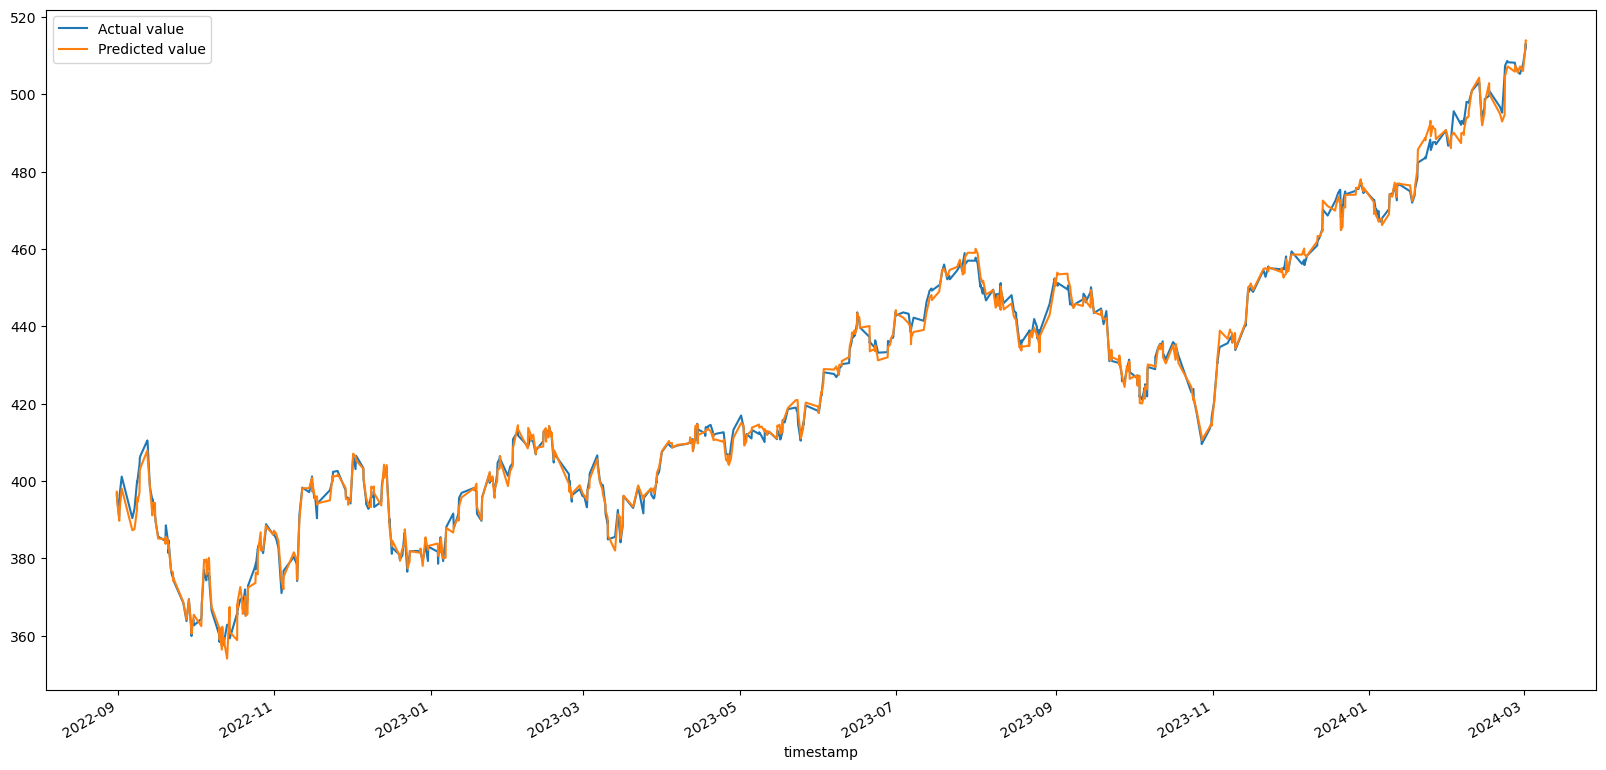

In [16]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': SGDpredictions})
reg_model_diff.plot(figsize=(20,10))

In [17]:
predict_df = pd.DataFrame(X, columns=['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close','XLK_close', 'XLV_close', 'XLP_close', 'ARKK_close', 'ICLN_close', 'ROBO_close'])
predict_df_scaled = pd.DataFrame(scaler.transform(predict_df))
last_rows = predict_df_scaled.tail(1)
#last_rows = scaler.transform(last_rows)
SGDnext = SGDmodel.predict(last_rows)
SGD_final = (SGDnext-df_portreo['SPY_close'].tail(1))/df_portreo['SPY_close'].tail(1) 
print(SGD_final)

timestamp
2024-03-01 21:00:00+00:00    0.003422
Name: SPY_close, dtype: float64


In [18]:
predict_df_scaled['predicted_value'] = SGDmodel.predict(predict_df_scaled)
predict_df_scaled['pct_change'] = predict_df_scaled['predicted_value'].pct_change()
predict_df_scaled.dropna(inplace=True)
predict_df_scaled['signals'] = 0
predict_df_scaled.loc[predict_df_scaled['pct_change'] > 0.002,'signals'] = 1
predict_df_scaled.loc[predict_df_scaled['pct_change'] < -0.002,'signals'] = -1
predict_df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,predicted_value,pct_change,signals
1,-0.409466,-0.217377,-1.074589,-1.393903,0.065882,-2.139973,-1.823320,0.133095,1.164132,-0.877802,-1.300818,0.439486,0.121282,1.728374,-1.015772,397.910883,-0.003134,-1
2,-0.383071,-0.195689,-1.076708,-1.419483,0.065882,-2.154537,-1.830644,0.201901,1.130160,-0.862485,-1.300818,0.468859,0.173684,1.741681,-1.020199,398.693507,0.001967,0
3,-0.435861,-0.246294,-1.104248,-1.462118,0.026310,-2.182858,-1.855056,0.132053,1.128989,-0.883526,-1.397830,0.357242,0.124193,1.735978,-1.031210,397.240481,-0.003644,-1
4,-0.453457,-0.340276,-1.116960,-1.479172,0.019714,-2.194995,-1.872144,0.085140,1.119617,-0.899972,-1.446336,0.339618,0.110161,1.734457,-1.054334,396.038618,-0.003026,-1
5,-0.497448,-0.387267,-1.123675,-1.501910,-0.052835,-2.220888,-1.889233,0.062205,1.103217,-0.907631,-1.451285,0.229959,0.126503,1.737879,-1.065258,395.546615,-0.001242,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,1.438165,2.070719,2.380714,0.752030,1.092567,1.244701,1.507426,2.387001,-1.220904,2.065974,2.690514,0.660762,1.958245,-1.324744,1.401157,512.275116,0.001160,0
2977,1.451363,2.067105,2.383892,0.754872,1.046927,1.216381,1.519900,2.395341,-1.218561,2.090966,2.742979,0.668595,1.994169,-1.320942,1.424347,513.128435,0.001666,0
2978,1.468959,2.049031,2.406136,0.757714,1.033209,1.205053,1.538209,2.409926,-1.215047,2.122810,2.718232,0.688177,1.996867,-1.315239,1.448572,513.911033,0.001525,0
2979,1.468959,2.030958,2.406115,0.763399,1.052995,1.192107,1.539430,2.423489,-1.209190,2.135104,2.722191,0.707759,1.965038,-1.317140,1.457382,514.271331,0.000701,0


In [19]:
#test
initial_capital = float(10000)
share_size = float(24)

predict_df_scaled["signal_diff"] = predict_df_scaled['signals'].diff()

predict_df_scaled['Entry/Exit Position'] = 0
predict_df_scaled['Trade Costs or Proceeds'] = 0
predict_df_scaled['Position'] = 0

Portfolio_Cash = initial_capital
held_shares = 0 
current_shares = 0
k = 0
j = 0
for index, row in predict_df_scaled.iterrows():
    max_share_size = (Portfolio_Cash//predict_df_scaled['predicted_value'].at[index])
    if index == 1:
        predict_df_scaled["Portfolio Cash"] = float(10000)
    
    elif (row['signals'] > 0) and (max_share_size > 0): 
        predict_df_scaled['Entry/Exit Position'].at[index] =  max_share_size
        predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
        predict_df_scaled["Portfolio Cash"].at[index] = Portfolio_Cash + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
        Portfolio_Cash =  predict_df_scaled["Portfolio Cash"].at[index]
        held_shares += predict_df_scaled['Entry/Exit Position'].at[index]
        share_size = max_share_size
        j = 0
        
    elif (row['signals'] < 0) and (held_shares > 0):
        if k == 0:
            k += 1
            predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
            predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1] + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
        else:
            predict_df_scaled['Entry/Exit Position'].at[index] = -(held_shares)
            predict_df_scaled['Trade Costs or Proceeds'].at[index] = -(predict_df_scaled['predicted_value'].at[index] * predict_df_scaled['Entry/Exit Position'].at[index])
            predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1] + (predict_df_scaled['Trade Costs or Proceeds'].at[index]).cumsum()
            Portfolio_Cash =  predict_df_scaled["Portfolio Cash"].at[index]
            held_shares = 0
            share_size = max_share_size
            k = 0
    else:
        predict_df_scaled["Portfolio Cash"].at[index] = predict_df_scaled["Portfolio Cash"].at[index-1]


for index, row in predict_df_scaled.iterrows():
    if row['Entry/Exit Position'] > 0:
        predict_df_scaled['Position'].at[index] = current_shares + row['Entry/Exit Position']
        current_shares = predict_df_scaled['Position'].at[index]
    elif row['Entry/Exit Position'] < 0:
        predict_df_scaled['Position'].at[index] = current_shares + row['Entry/Exit Position'] 
        current_shares = predict_df_scaled['Position'].at[index]
    else:
        predict_df_scaled['Position'].at[index] = current_shares
      

    
predict_df_scaled["Stock Holdings"] = (predict_df_scaled["predicted_value"] * predict_df_scaled["Position"])

predict_df_scaled["Portfolio Total"] = predict_df_scaled['Portfolio Cash'] + predict_df_scaled['Stock Holdings']

predict_df_scaled["Portfolio Daily Returns"] = predict_df_scaled['Portfolio Total'].pct_change()

predict_df_scaled["Portfolio Cumulative Returns"] = (predict_df_scaled['Portfolio Total'] - initial_capital)/initial_capital  #(1 + predict_df_scaled['Portfolio Daily Returns']).cumprod() - 1

predict_df_scaled.dropna(inplace=True)

predict_df_scaled.iloc[:,14:].head()


,14,predicted_value,pct_change,signals,signal_diff,Entry/Exit Position,Trade Costs or Proceeds,Position,Portfolio Cash,Stock Holdings,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2,-1.020199,398.693507,0.001967,0,1.0,0,0.0,0,10000.0,0.0,10000.0,0.0,0.0
3,-1.031210,397.240481,-0.003644,-1,-1.0,0,0.0,0,10000.0,0.0,10000.0,0.0,0.0
4,-1.054334,396.038618,-0.003026,-1,0.0,0,0.0,0,10000.0,0.0,10000.0,0.0,0.0
5,-1.065258,395.546615,-0.001242,0,1.0,0,0.0,0,10000.0,0.0,10000.0,0.0,0.0
6,-1.053233,394.795417,-0.001899,0,0.0,0,0.0,0,10000.0,0.0,10000.0,0.0,0.0


In [20]:
predict_df_scaled.tail()

,0,1,2,3,4,5,6,7,8,9,...,signals,signal_diff,Entry/Exit Position,Trade Costs or Proceeds,Position,Portfolio Cash,Stock Holdings,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2976,1.438165,2.070719,2.380714,0.752030,1.092567,1.244701,1.507426,2.387001,-1.220904,2.065974,...,0,-1.0,0,0.0,25,235.193102,12806.877902,13042.071003,0.001139,0.304207
2977,1.451363,2.067105,2.383892,0.754872,1.046927,1.216381,1.519900,2.395341,-1.218561,2.090966,...,0,0.0,0,0.0,25,235.193102,12828.210868,13063.403969,0.001636,0.306340
2978,1.468959,2.049031,2.406136,0.757714,1.033209,1.205053,1.538209,2.409926,-1.215047,2.122810,...,0,0.0,0,0.0,25,235.193102,12847.775817,13082.968919,0.001498,0.308297
2979,1.468959,2.030958,2.406115,0.763399,1.052995,1.192107,1.539430,2.423489,-1.209190,2.135104,...,0,0.0,0,0.0,25,235.193102,12856.783278,13091.976380,0.000688,0.309198
2980,1.468959,2.002040,2.401899,0.760557,1.046399,1.180778,1.545533,2.395341,-1.224418,2.126841,...,0,0.0,0,0.0,25,235.193102,12849.321383,13084.514485,-0.000570,0.308451


In [21]:
predict_df_scaled['Portfolio Total'].iloc[-1]

13084.514484713627

In [22]:
#15
#Set logic for signal
if SGDnext > 0.005:
    SGDprediction = 1
elif SGDnext < -0.005:
    SGDprediction = -1
elif -0.005 <= SGDnext <= 0.005:
    SGDprediction = 0
    
SGDprediction

1

In [23]:
'''
#Prophet Model Section, no good prediction#

#14
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import seaborn as sns
from datetime import datetime, timezone
%matplotlib inline

interim = df_portreo.copy()
interim.reset_index(inplace=True)
prophet_model = interim[['timestamp', 'SPY_close']]
prophet_model['timestamp'] = prophet_model['timestamp'].apply(lambda d: d.replace(tzinfo=None))
prophet_model.rename(columns={"timestamp":"ds", "SPY_close":"y"}, inplace=True)

#display(prophet_model)


#Plotting Trends Dataframe'

display(prophet_model.hvplot(title= "Trends", xlabel="Date",ylabel="Closing Prices", xticks="symbol"))


Prophet_trends=Prophet()

Prophet_trends.fit(prophet_model)

Prophet_trends_forecast = Prophet_trends.make_future_dataframe(periods=365, freq='D')
#Prophet_trends_forecast
forecast = Prophet_trends.predict(Prophet_trends_forecast)
forecast

forecast[['yhat', 'yhat_lower', 'yhat_upper']].hvplot()
fig2 = Prophet_trends.plot_components(forecast)
'''

'\n#Prophet Model Section, no good prediction#\n\n#14\nimport pandas as pd\nimport holoviews as hv\nfrom prophet import Prophet\nimport hvplot.pandas\nimport seaborn as sns\nfrom datetime import datetime, timezone\n%matplotlib inline\n\ninterim = df_portreo.copy()\ninterim.reset_index(inplace=True)\nprophet_model = interim[[\'timestamp\', \'SPY_close\']]\nprophet_model[\'timestamp\'] = prophet_model[\'timestamp\'].apply(lambda d: d.replace(tzinfo=None))\nprophet_model.rename(columns={"timestamp":"ds", "SPY_close":"y"}, inplace=True)\n\n#display(prophet_model)\n\n\n#Plotting Trends Dataframe\'\n\ndisplay(prophet_model.hvplot(title= "Trends", xlabel="Date",ylabel="Closing Prices", xticks="symbol"))\n\n\nProphet_trends=Prophet()\n\nProphet_trends.fit(prophet_model)\n\nProphet_trends_forecast = Prophet_trends.make_future_dataframe(periods=365, freq=\'D\')\n#Prophet_trends_forecast\nforecast = Prophet_trends.predict(Prophet_trends_forecast)\nforecast\n\nforecast[[\'yhat\', \'yhat_lower\', \

In [46]:
#16
# import libraries (potentially remove this block of code if redundant)
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [47]:
#16.a
#Set up dataframe with SPY percent changes

df_portreo['SPY_pct'] = df_portreo['SPY_close'].pct_change().dropna()
df_portreo.dropna(inplace=True)

In [48]:
#16.b
# Set categories for target 

df_portreo.loc[df_portreo['SPY_pct'] > 0.005,'y'] = 1
df_portreo.loc[df_portreo['SPY_pct'] < -0.005,'y'] = -1
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close,XLK_close,XLV_close,XLP_close,ARKK_close,ICLN_close,ROBO_close,SPY_pct,y
timestamp,,,,,,,,,,,,,,,,,,
2022-09-01 13:00:00+00:00,392.8050,21.720,33.190,52.990,28.370,30.380,44.10,34.720,180.33,49.090,133.6800,125.060,72.950,40.620,21.8100,45.8500,-0.007040,-1.0
2022-09-01 14:00:00+00:00,390.3404,21.540,33.085,52.660,28.205,29.970,43.74,34.380,179.32,48.690,132.2100,124.760,72.870,40.005,21.4550,45.3670,-0.006274,-1.0
2022-09-01 18:00:00+00:00,394.2700,21.670,33.300,52.840,28.370,30.370,44.80,34.720,180.50,49.010,133.6600,126.295,73.450,41.000,21.6800,45.8500,0.005457,1.0
2022-09-01 19:00:00+00:00,396.4000,21.730,33.380,52.960,28.430,30.440,44.63,34.810,181.50,49.230,134.5862,126.790,73.640,41.730,21.8000,46.0000,0.005402,1.0
2022-09-02 14:00:00+00:00,400.3800,22.120,34.070,53.075,28.890,31.265,45.74,35.575,183.56,48.795,136.1000,127.300,74.145,41.790,21.7950,46.5400,0.005929,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14 14:00:00+00:00,496.8800,23.240,35.635,66.780,31.950,32.640,67.28,47.090,197.53,37.860,204.1000,143.570,72.630,49.455,14.3250,55.2403,0.005158,1.0
2024-02-16 14:00:00+00:00,499.6600,23.640,36.620,67.480,32.565,32.890,67.20,47.720,201.80,38.960,203.1500,145.260,73.080,50.715,14.5079,56.1300,-0.005375,-1.0
2024-02-21 20:00:00+00:00,497.1700,23.625,36.490,67.800,32.655,33.680,67.12,48.315,197.94,39.270,199.1600,145.450,74.305,47.370,14.1500,55.9100,0.005237,1.0


In [49]:
#17
# Scale dataframe

X = df_portreo.drop(columns=['SPY_close', 'SPY_pct', 'y'])
y = df_portreo['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [50]:
#17.a
# set up neurons

number_inputs = 15
number_hidden_nodes = 8
neuron = Sequential()
neuron.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="selu"))
neuron.add(Dense(units=number_hidden_nodes//2, activation= "selu"))
# Add the output layer to the model specifying the number of output neurons and activation function
neuron.add(Dense(1, activation="Softmax"))


In [51]:
#17.a
#Check summary of parameters

neuron.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 128       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
#18
# Compile the Sequential model
neuron.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [53]:
#19
# Fit the model using 100 epochs and the training data
model = neuron.fit(X_train, y_train, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 3/100
8/8 [==============================] - 0s 931us/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 5/100
8/8 [==============================] - 0s 931us/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 6/100
8/8 [==============================] - 0s 930us/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 9/100
8/8 [==============================] - 0s 931us/step - loss: 0.0000e+00 - accuracy: 0.5172
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0000e+00 

In [54]:
#20
# jahun - Algo trading
# Buy sell signals
# Set the orderSide variable (which is used in the API call coming up next) --- buy, sell, hold
if SGDprediction == 1:
    orderSide = "buy"
elif SGDprediction == -1:
    orderSide = "sell"
else:
    orderSide = "hold"
# Determining the number of shares
number_of_shares = 100
# create a boolean for the orderside to be buy or sell
if orderSide == "buy" or orderSide == "sell":
    # Submit order
    alpaca.submit_order(
        symbol="SPY",
        qty=number_of_shares,
        side=orderSide,
        time_in_force='gtc',
        type="limit",
        #limit = SGDnext
    )


APIError: request is not authorized

In [ ]:
#21

In [ ]:
#22

In [ ]:
#23

In [ ]:
#24